In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load and preprocess the MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0
x_train = np.expand_dims(x_train, axis=-1)

# Define constants
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 50
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

# Prepare the dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:

# Generator model
def make_generator_model():
    model = Sequential([
        Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)),
        BatchNormalization(),
        LeakyReLU(),

        Reshape((7, 7, 256)),

        Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Discriminator model
def make_discriminator_model():
    model = Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        LeakyReLU(),
        BatchNormalization(),

        Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        BatchNormalization(),

        Flatten(),
        Dense(1)
    ])
    return model

# Loss function for both discriminator and generator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

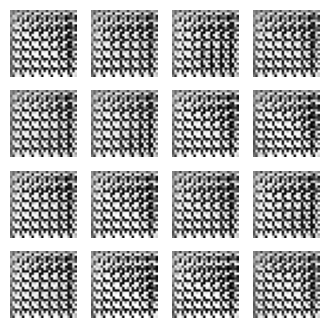

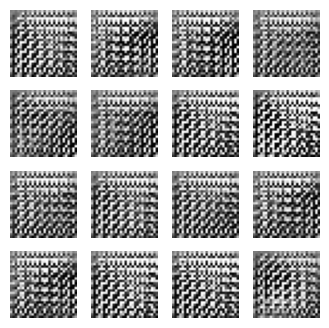

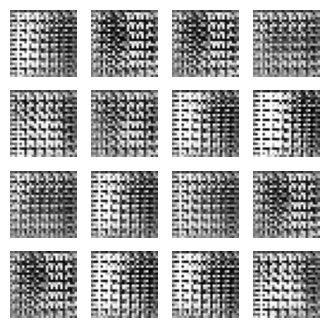

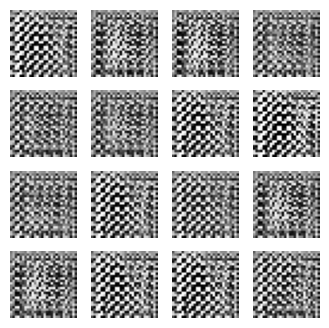

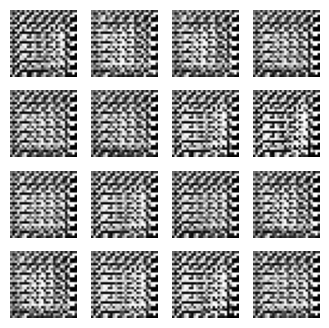

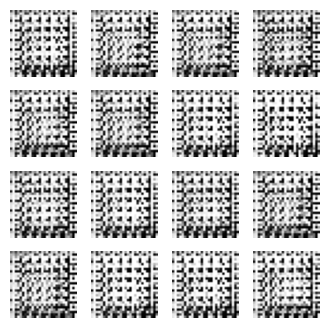

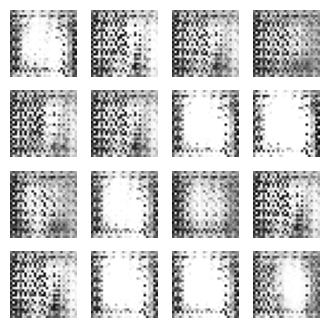

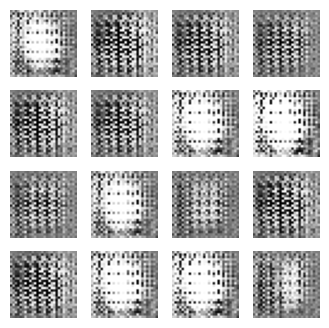

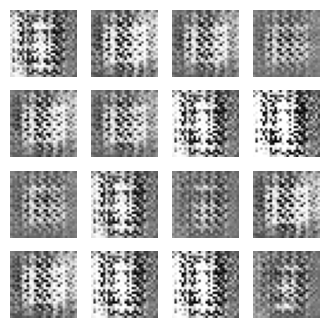

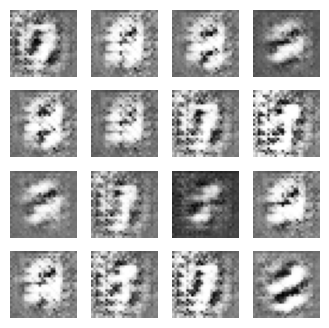

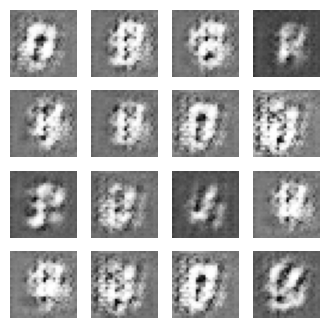

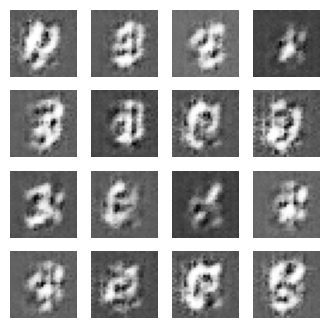

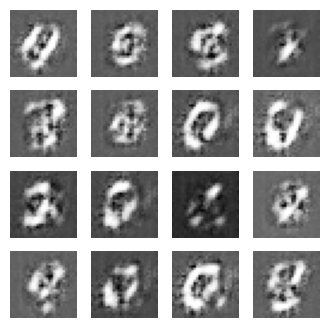

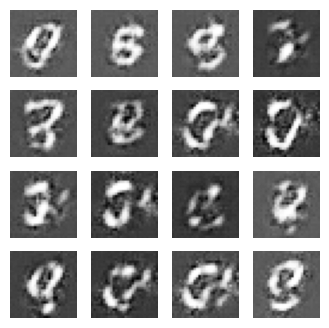

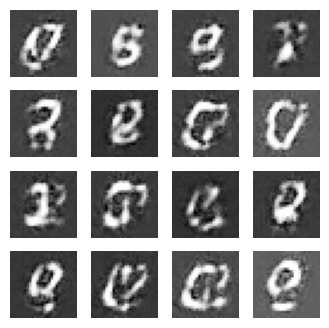

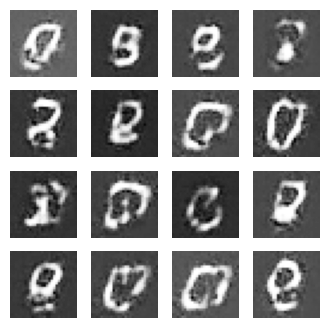

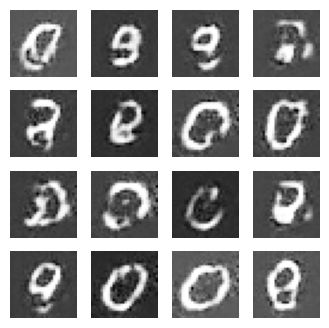

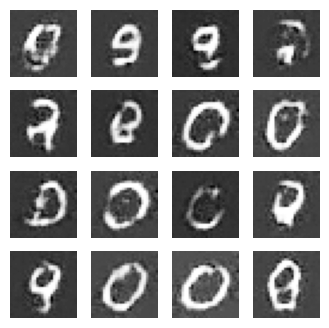

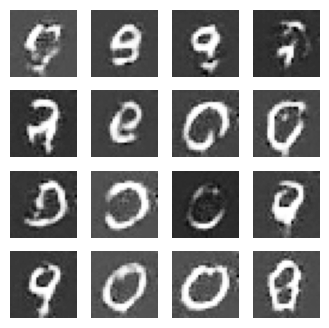

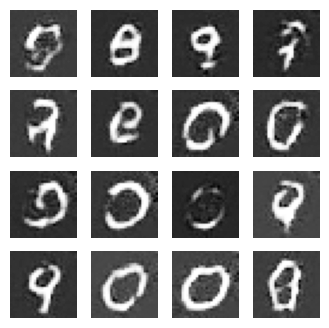

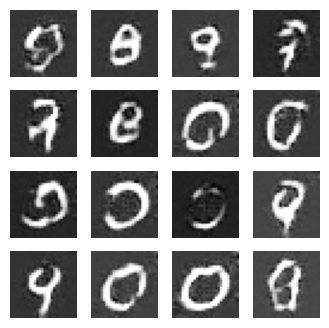

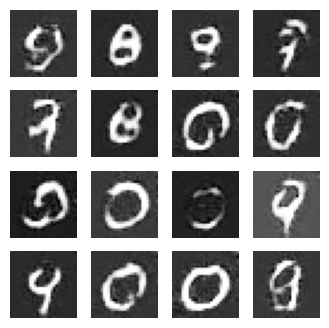

In [ ]:
import os

# Instantiate the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the optimizers
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# Checkpoint to save the model
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Generate seed for consistent images
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    # Generate after the final epoch
    generate_and_save_images(generator, epochs, seed)

# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Train the GAN
train(train_dataset, EPOCHS)
